## xcube Data Store Framework - SENTINEL Hub

This notebook walks provides a walk-through demonstrating how to use xcube and the xcube SENTINEL Hub (SH) plugin to read and explore data from the SENTINEL Hub.

**Please note:**  
In order to be able to access data from SENTINEL Hub, you need SENTINEL Hub Credentials as well as a SH_INSTANCE_ID, which are exported as envrionment variables.  
In case you have not exported them already, you may also set them by uncommenting the cell below and adjusting the content to your access credentials. 

In [1]:
# os.environ["SH_CLIENT_ID"] =  your_sh_client_id
# os.environ["SH_CLIENT_SECRET"] = your_sh_client_secret
# os.environ["SH_INSTANCE_ID="] = your_sh_instance_id

In [2]:
from xcube.core.store import find_data_store_extensions
from xcube.core.store import get_data_store_params_schema
from xcube.core.store import new_data_store

# Various utilities
import shapely.geometry
import IPython.display
from IPython.display import JSON
import matplotlib.pyplot as plt


Configure matplotlib to display graphs inline directly in the notebook and set a sensible default figure size.

In [3]:
%matplotlib inline
plt.rcParams["figure.figsize"] = 16,12


First, let's have a look at the data accessors. Which data accessors are available?

In [4]:
JSON({e.name: e.metadata for e in find_data_store_extensions()})

<IPython.core.display.JSON object>

The data stores may offer different initialization options. Some of the options are mandatory. Let's have a look at the parameters for this store.

In [5]:
get_data_store_params_schema('sentinelhub')

Provide mandatory parameters to instantiate the store class:

In [6]:
store = new_data_store('sentinelhub', num_retries=400)
store

Which datasets are provided? (the list may contain both gridded and vector datasets):

In [7]:
JSON(list(store.get_data_ids()))

<IPython.core.display.JSON object>

Which "openers" are available? Note, the first part of an opener's name identifies the returned in-memory data type:

- `dataset` --> `xarray.Dataset` (Gridded data)
- `mldataset` -->  `xcube.core.mlds.MultiLevelDataset`  (Gridded data, multi-resolution pyramid)
- `geodataframe` --> `geopandas.GeoDataFrame` (Vector data) 

The first opener is the default opener. In this case there is only a single one:

In [8]:
store.get_data_opener_ids()

('dataset:zarr:sentinelhub',)

Get more info about a dedicated dataset. This include a description of the possible open formats:

In [9]:
store.describe_data('S2L2A')

Which parameters must be passsed or are available to open the dataset? 

In [10]:
store.get_open_data_params_schema('S2L2A')

There are 3 required parameters, so we need to provide them to open a dataset, one of them being bbox. Let's set a region covering Hamburg:

In [11]:
bbox=[9.7, 53.4, 10.2, 53.7]

Take a look at the bbox in order to make sure the area is correctly set: 

In [12]:
IPython.display.GeoJSON(shapely.geometry.box(*bbox).__geo_interface__)

<IPython.display.GeoJSON object>

Now set the other parameters for opening the dataset from the store: 

In [13]:
dataset = store.open_data('S2L2A', 
                          variable_names=['B04'], 
                          bbox=bbox, 
                          spatial_res=0.00018, 
                          time_range=('2020-08-10T00:00:00+00:00','2020-08-20T00:00:00+00:00'), 
                          time_period='1D')
                          # tile_size= [1024,1024])
dataset

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 2325, lon: 3873, time: 11)
Coordinates:
  * lat        (lat) float64 53.82 53.82 53.82 53.82 ... 53.4 53.4 53.4 53.4
  * lon        (lon) float64 9.7 9.7 9.7 9.701 9.701 ... 10.4 10.4 10.4 10.4
  * time       (time) datetime64[ns] 2020-08-10T12:00:00 ... 2020-08-20T12:00:00
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(11, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B04        (time, lat, lon) float32 dask.array<chunksize=(1, 775, 1291), meta=np.ndarray>
Attributes:
    Conventions:               CF-1.7
    title:                     S2L2A Data Cube Subset
    history:                   [{'program': 'xcube_sh.chunkstore.SentinelHubC...
    date_created:              2020-10-30T11:29:26.572647
    processing_level:          L2A
    time_coverage_start:       2020-08-10T00:00:00+00:00
    time_coverage_end:         2020-08-21T00:00:00+00:00
    time_coverage_duration:    P11DT0H0M0S
    time_coverage_resolution:  P1DT0H0M0S
    geospatial_lon_min:        9.7
    geospatial_lat_min:        53.4
    geospatial_lon_max:        10.39714
    geospatial_lat_max:        53.8185

For further information, a description about the dataset and the bands may be found here: https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/ .

Plot one time stamp of the dataset for our requested variable: 

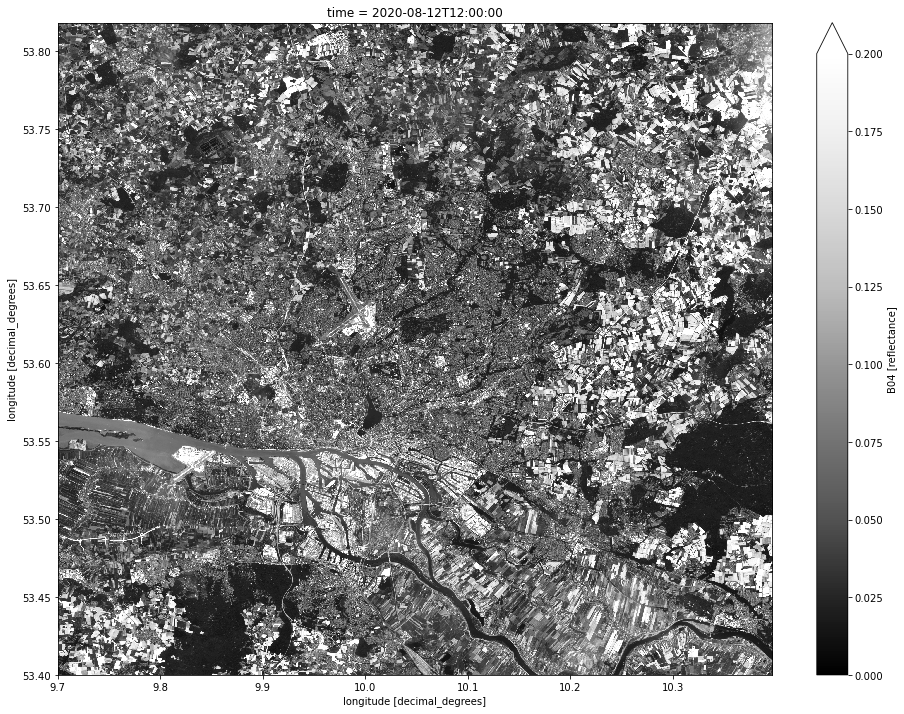

In [17]:
dataset.B04.isel(time=2).plot.imshow(vmin=0, vmax=0.2, cmap='Greys_r')